Analyse some recent GOLEM shots from 25000 to 26023. 

# Getting data

The dataset has been created from the [GolSQL tool](http://golem.fjfi.cvut.cz/utils/miner), with the follow URL used to generate the dataset:


In [83]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [84]:
dataset = pd.read_csv('close_shots.txt', delimiter='\s+', index_col='shots')

In [85]:
dataset.head()

,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,ucd,tcd,breakdown_voltage,plasma_life,...,tbd,breakdown_rate_err,ubd,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max,ub
shots,,,,,,,,,,,,,,,,,,,,,
20000,10.275,0.0036,0.0675,0.086171,0.005,19.339,500.0,0.006,10.501,0.00874,...,0.005,NaN,0.0,NaN,NaN,NaN,12.4140,0.0135,15.140,1000.0
20001,10.275,0.0036,0.0675,NaN,0.005,NaN,400.0,0.011,NaN,NaN,...,0.005,NaN,0.0,NaN,NaN,NaN,NaN,0.0135,11.105,600.0
20002,10.236,0.0036,0.0675,0.164820,0.005,16.332,400.0,0.011,10.225,0.00746,...,0.005,NaN,0.0,NaN,NaN,NaN,9.4531,0.0135,13.707,600.0
20003,10.275,0.0036,0.0675,0.064730,0.005,21.470,500.0,0.006,11.843,0.00666,...,0.005,NaN,0.0,NaN,NaN,NaN,10.3120,0.0135,18.776,600.0
20004,10.275,0.0036,0.0675,0.193450,0.005,16.559,400.0,0.013,10.286,0.00762,...,0.005,NaN,0.0,NaN,NaN,NaN,9.4195,0.0135,13.575,600.0


# Cleaning data

Filter bad shots from the dataset, as adviced in the [GOLEM DataMining Page](http://golem.fjfi.cvut.cz/wiki/Handling/DataMining/data_mining)

In [86]:
print(len(dataset)) # number of shot before cleaning 

5996


In [87]:
# Drop failed plasma
dataset = dataset.dropna(subset=['plasma'])

# Drop plasma longer than 25 ms
dataset = dataset.drop(dataset[dataset['plasma_life'] > 25e-3].index)

# Drop loop voltage below than 5V
dataset = dataset.drop(dataset[dataset['loop_voltage_max'] < 5].index)

# Drop pressure larger than 100mPa
dataset = dataset.drop(dataset[dataset['pressure'] > 100].index)

# number of shot after cleaning
print(len(dataset)) 

5665


# Which parameters to improve the plasma lifetime?

In [88]:
# get the longest shots
dataset.sort_values('plasma_life', ascending=False).head()

,pressure_initial,cbd,cb,breakdown_field,tb,electron_temperature_max,ucd,tcd,breakdown_voltage,plasma_life,...,tbd,breakdown_rate_err,ubd,breakdown_probability,discharge_aborted,pressure_chamber,loop_voltage_mean,ccd,loop_voltage_max,ub
shots,,,,,,,,,,,,,,,,,,,,,
23800,0.13277,0.0036,0.0675,0.061511,0.005,NaN,400.0,0.005,8.4863,0.02498,...,0.005,NaN,0.0,89.0,NaN,NaN,4.2969,0.0135,7.9022,1300.0
25341,0.19639,0.0036,0.0675,0.068972,0.005,NaN,400.0,0.005,8.8824,0.02498,...,0.005,NaN,0.0,89.0,NaN,NaN,4.5386,0.0135,8.2084,1300.0
24292,0.22723,0.0036,0.0675,0.070704,0.005,84.685,450.0,0.005,9.9164,0.02494,...,0.005,NaN,0.0,93.0,NaN,NaN,4.6930,0.0135,9.5740,1300.0
25483,0.56435,0.0036,0.0675,0.068445,0.005,NaN,400.0,0.005,9.2651,0.02494,...,0.005,NaN,0.0,90.0,NaN,NaN,4.5117,0.0135,8.7884,1300.0
25479,0.54102,0.0036,0.0675,0.068554,0.005,NaN,400.0,0.005,9.2517,0.02486,...,0.005,NaN,0.0,90.0,NaN,NaN,4.4916,0.0135,8.7482,1300.0


According to the GOLEM documentation, the following parameters can be tuned for each plasma shot:

 - Toroidal Magnetic Field, set by $U_B$
 - Current Drive, set bu $U_{CD}$
 - Time delay for Current Drive, $\tau_{CD}$
 - Filling Pressure, $p_{WG}$ [mPa]
 
So let's look for the set of parameters which maximize the plasma duration

In [89]:
reduced_set = dataset[['ub', 'ucd', 'tcd', 'pressure_request','plasma_life']].dropna()
reduced_set.sort_values('plasma_life', ascending=False).head()

,ub,ucd,tcd,pressure_request,plasma_life
shots,,,,,
23800,1300.0,400.0,0.005,20,0.02498
25341,1300.0,400.0,0.005,20,0.02498
24292,1300.0,450.0,0.005,20,0.02494
25483,1300.0,400.0,0.005,20,0.02494
25479,1300.0,400.0,0.005,20,0.02486


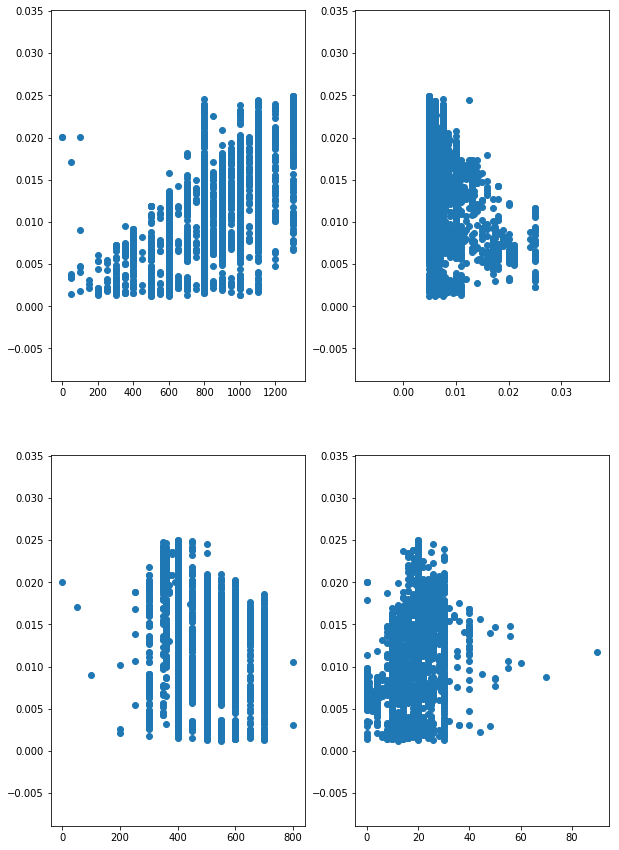

In [90]:
fig, ax = plt.subplots(2, 2, figsize=(10,15))
ax[0,0].scatter(reduced_set['ub'], reduced_set['plasma_life'])
ax[1,0].scatter(reduced_set['ucd'], reduced_set['plasma_life'])
ax[0,1].scatter(reduced_set['tcd'], reduced_set['plasma_life'])
ax[1,1].scatter(reduced_set['pressure_request'], reduced_set['plasma_life'])

The question is : what is the set of parameters $\{u_B, u_{CD}, \tau_{CD}, p\}$ which maximize the plasma duration ? 

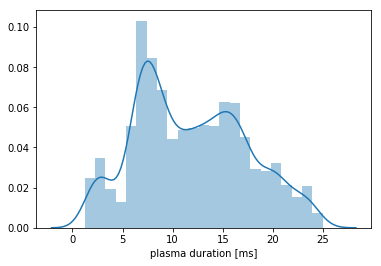

In [91]:
seaborn.distplot(reduced_set['plasma_life']*1e3, axlabel='plasma duration [ms]')

So, how to produce a plasma duration larger than 15 ms ?

In [92]:
longest_shots = reduced_set[reduced_set['plasma_life'] > 15e-3]

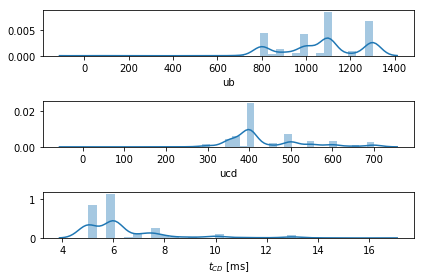

In [93]:
fig, ax = plt.subplots(3,1)
seaborn.distplot(longest_shots['ub'], ax=ax[0])
seaborn.distplot(longest_shots['ucd'], ax=ax[1])
seaborn.distplot(longest_shots['tcd']*1e3, ax=ax[2], axlabel='$t_{CD}$ [ms]')
fig.tight_layout()